In [1]:
'''Importing basic data analysis packages'''
import numpy as np
import pandas as pd
import csv
import warnings
import os
import time
warnings.filterwarnings('ignore')
os.getcwd()

'''Plotting packages'''
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.3)

p1 = pd.read_csv('p1.csv')
print('PLEDGE 1% cols: {}\nSHAPE: {}\n'.format(p1.columns.to_list(), p1.shape))

#################
# Organizations #
#################
print('*'*100)

ppl = pd.read_csv('people.csv')
print('PEOPLE cols: {}\nSHAPE: {}\n'.format(ppl.columns.to_list(), ppl.shape))

jobs = pd.read_csv('jobs.csv') # All jobs affiliated with company
print('JOBS cols: {}\nSHAPE: {}'.format(jobs.columns.to_list(), jobs.shape))

org = pd.read_csv('organizations.csv')
print('ORGANIZATION/org cols: {}\nSHAPE: {}\n'.format(org.columns.to_list(), org.shape))

invest = pd.read_csv('investments.csv')
print('INVESTMENTS/invest cols: {}\nSHAPE: {}\n'.format(invest.columns.to_list(), invest.shape))

fund_rnds = pd.read_csv('funding_rounds.csv')
print('FUNDING ROUNDS/fund_rnds cols: {}\nSHAPE: {}\n'.format(fund_rnds.columns.to_list(), fund_rnds.shape))

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

FileNotFoundError: [Errno 2] File p1.csv does not exist: 'p1.csv'

In [9]:
## Top investors of P1 companies
# combine org with p1 dataset on uuid
df_org = pd.merge(org.copy(),p1.copy(),how='outer',on='uuid')
print("Records in org dataframe",df_org.shape)

# typecast p1_tag to boolean(0 or 1)
df_org['p1_tag'] = df_org['p1_tag'].apply(lambda x: 1 if x == True else 0)
df_org['employee_count'] = df_org['employee_count'].apply(lambda x: np.NaN if x == 'unknown' else x)
df_org = df_org[['uuid','name','rank','status','p1_date','total_funding_usd','p1_tag']]

# Filter for only pledge1 companies
df_org = reduce_mem_usage(df_org)
df_org = df_org[df_org['p1_tag'] == 1].sort_values('p1_date')
print("Records in df_org dataframe(only p1 data)",df_org.shape)

# join df_org with fund_rnds dataset
df_org['org_uuid'] = df_org['uuid']
fund_rnds['funding_round_uuid'] = fund_rnds['uuid']

# merge df_org with fund_rnds on org_uuid
df_org = pd.merge(df_org.copy(),fund_rnds.copy(),how='outer',on='org_uuid')

# exclude NAN values
df_org = df_org[~df_org['org_uuid'].isna()].sort_values('p1_date')

# reduce memory
df_org = reduce_mem_usage(df_org)

# select attributes
df_org = df_org[['funding_round_uuid','org_uuid','name_x','name_y','type','permalink','rank_x','status','p1_date','total_funding_usd', \
                         'p1_tag','org_name','raised_amount','raised_amount_usd','post_money_valuation_usd', \
                         'post_money_valuation_currency_code','lead_investor_uuids']]


# merge df_org with invest dataset on funding_round_uuid
df_org = pd.merge(invest.copy(),df_org.copy(),how='outer',on='funding_round_uuid')
df_org = reduce_mem_usage(df_org)

# filter the records that do not have a matching funding_round_uuid
df_org = df_org[~df_org['funding_round_uuid'].isna()].sort_values('p1_date')

df_org.head()

Records in org dataframe (66523, 43)
Mem. usage decreased to  3.11 Mb (23.4% reduction)
Records in df_org dataframe(only p1 data) (7822, 7)
Mem. usage decreased to 24.73 Mb (12.5% reduction)
Mem. usage decreased to 34.82 Mb (0.0% reduction)
Records in df_org dataframe after all merges (157363, 30)


,uuid,name,type_x,permalink_x,cb_url,rank,created_at,updated_at,funding_round_uuid,funding_round_name,...,status,p1_date,total_funding_usd,p1_tag,org_name,raised_amount,raised_amount_usd,post_money_valuation_usd,post_money_valuation_currency_code,lead_investor_uuids
94781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c2ca27bf-9f82-c5f4-8189-5df17ade92c6,NaN,...,NaN,1/1/2018,NaN,1.0,Bartesian,NaN,NaN,NaN,USD,39041e62-6b24-ae8d-1347-4cea947e832c
57041,74ea080a-241c-3657-d8ba-cccd1311b88f,Catamount Ventures investment in Series B - Pr...,investment,catamount-ventures-invested-in-presencelearnin...,https://www.crunchbase.com/investment/catamoun...,NaN,2013-04-26 13:14:27,2018-02-13 00:53:41,2d098363-4316-a662-f2f2-eb406a7f7b7b,Series B - PresenceLearning,...,NaN,1/10/2017,NaN,1.0,PresenceLearning,8000000.0,8000000.0,NaN,USD,"1a63f307-31be-f811-f115-ed45a3aba43e,67a9c508-..."
57040,79a3fe7d-1d06-7191-1f04-460f1fad58a2,Blue Heron Capital investment in Series B - Pr...,investment,blue-heron-capital-invested-in-presencelearnin...,https://www.crunchbase.com/investment/blue-her...,NaN,2013-04-26 13:14:27,2018-02-13 00:53:46,2d098363-4316-a662-f2f2-eb406a7f7b7b,Series B - PresenceLearning,...,NaN,1/10/2017,NaN,1.0,PresenceLearning,8000000.0,8000000.0,NaN,USD,"1a63f307-31be-f811-f115-ed45a3aba43e,67a9c508-..."
57039,fa73b4cc-374c-de62-37ee-3b71fcba6eb0,Allen & Company LLC investment in Series B - P...,investment,allen-and-company-invested-in-presencelearning...,https://www.crunchbase.com/investment/allen-an...,NaN,2013-04-26 13:14:27,2018-02-13 00:56:37,2d098363-4316-a662-f2f2-eb406a7f7b7b,Series B - PresenceLearning,...,NaN,1/10/2017,NaN,1.0,PresenceLearning,8000000.0,8000000.0,NaN,USD,"1a63f307-31be-f811-f115-ed45a3aba43e,67a9c508-..."
57038,c4cf95aa-ab63-6c53-b229-6576899024ea,New Markets Venture Partners investment in Ser...,investment,new-markets-venture-partners-invested-in-prese...,https://www.crunchbase.com/investment/new-mark...,NaN,2013-04-26 13:14:26,2018-02-13 00:55:29,2d098363-4316-a662-f2f2-eb406a7f7b7b,Series B - PresenceLearning,...,NaN,1/10/2017,NaN,1.0,PresenceLearning,8000000.0,8000000.0,NaN,USD,"1a63f307-31be-f811-f115-ed45a3aba43e,67a9c508-..."


In [3]:

# create p1 dataset grouped on investor_name by aggregating raised_amount_usd
df_p1_100 = df_org.groupby('investor_name',as_index=False).agg({"raised_amount_usd":"sum"}).\
sort_values('raised_amount_usd',ascending=False)[0:100]
df_p1_100.head()


,investor_name,raised_amount_usd
8515,Kleiner Perkins,1.498892e+10
10663,New Enterprise Associates,1.112776e+10
249,Accel,9.598166e+09
13518,Sequoia Capital,8.377767e+09
6970,Intel Capital,8.240646e+09


In [4]:
## Top people of P1 companies
# combine org with p1 dataset on uuid
p1_org = pd.merge(org.copy(),p1.copy(),how='outer',on='uuid')
print("Records in org dataframe",p1_org.shape)

# typecast p1_tag to boolean(0 or 1)
p1_org['p1_tag'] = p1_org['p1_tag'].apply(lambda x: 1 if x == True else 0)
p1_org['employee_count'] = p1_org['employee_count'].apply(lambda x: np.NaN if x == 'unknown' else x)
p1_org = p1_org[['uuid','name','rank','status','p1_date','total_funding_usd','p1_tag']]

# Filter for only pledge1 companies
p1_org = reduce_mem_usage(p1_org)
p1_org = p1_org[p1_org['p1_tag'] == 1].sort_values('p1_date')
print("Records in df_org dataframe(only p1 data)",p1_org.shape)

p1_org['featured_job_organization_uuid'] = p1_org['uuid']
df_ppl_org = pd.merge(ppl.copy(),p1_org.copy(),how='outer',on='featured_job_organization_uuid')
df_ppl_org['person_name'] = df_ppl_org['name_x']
df_ppl_org['org_name'] = df_ppl_org['name_y']
df_ppl_org = df_ppl_org[['person_name','first_name','last_name','gender','city','country_code','featured_job_organization_uuid','featured_job_title',
                        'featured_job_organization_name','p1_date']]

# join df_org with fund_rnds dataset
df_ppl_org['org_uuid'] = df_ppl_org['featured_job_organization_uuid']

# merge df_org with fund_rnds on org_uuid
df_ppl_org = pd.merge(df_ppl_org.copy(),fund_rnds.copy(),how='outer',on='org_uuid')

# exclude NAN values
df_ppl_org_fnd = df_ppl_org[['org_uuid','person_name','first_name','last_name','gender','city_x','country_code_x','featured_job_organization_uuid','featured_job_title',
                        'featured_job_organization_name','p1_date','raised_amount_usd']]
df_ppl_org_fnd = df_ppl_org_fnd[~df_ppl_org_fnd['org_uuid'].isna()].sort_values('p1_date')
df_ppl_org_fnd = df_ppl_org_fnd[~df_ppl_org_fnd['raised_amount_usd'].isna()]
df_ppl_org_fnd = df_ppl_org_fnd[~df_ppl_org_fnd['person_name'].isna()]

# reduce memory
df_ppl_org_fnd = reduce_mem_usage(df_ppl_org_fnd)

df_ppl_org_fnd.head()

Records in org dataframe (66523, 43)
Mem. usage decreased to  3.11 Mb (23.4% reduction)
Records in df_org dataframe(only p1 data) (7822, 7)
Mem. usage decreased to  5.78 Mb (3.8% reduction)


,org_uuid,person_name,first_name,last_name,gender,city_x,country_code_x,featured_job_organization_uuid,featured_job_title,featured_job_organization_name,p1_date,raised_amount_usd
114967,ae3a3925-c305-9b89-d764-33b3097f87bc,Andrew Davies,Andrew,Davies,male,London,GBR,ae3a3925-c305-9b89-d764-33b3097f87bc,Co-Founder & CMO,Idio,1/18/2016,2350000.0
114968,ae3a3925-c305-9b89-d764-33b3097f87bc,Andrew Davies,Andrew,Davies,male,London,GBR,ae3a3925-c305-9b89-d764-33b3097f87bc,Co-Founder & CMO,Idio,1/18/2016,6200000.0
114966,ae3a3925-c305-9b89-d764-33b3097f87bc,Andrew Davies,Andrew,Davies,male,London,GBR,ae3a3925-c305-9b89-d764-33b3097f87bc,Co-Founder & CMO,Idio,1/18/2016,250000.0
114965,ae3a3925-c305-9b89-d764-33b3097f87bc,Edward Barrow,Edward,Barrow,male,London,GBR,ae3a3925-c305-9b89-d764-33b3097f87bc,Co-Founder & CEO,Idio,1/18/2016,6200000.0
114964,ae3a3925-c305-9b89-d764-33b3097f87bc,Edward Barrow,Edward,Barrow,male,London,GBR,ae3a3925-c305-9b89-d764-33b3097f87bc,Co-Founder & CEO,Idio,1/18/2016,2350000.0


In [5]:
# create p1 dataset grouped on investor_name by aggregating raised_amount_usd
df_p1_ppl_100 = df_ppl_org_fnd.groupby('person_name',as_index=False).agg({"raised_amount_usd":"sum"}).\
sort_values('raised_amount_usd',ascending=False)[0:100]

In [6]:
# categorize amounts in billion using plots

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

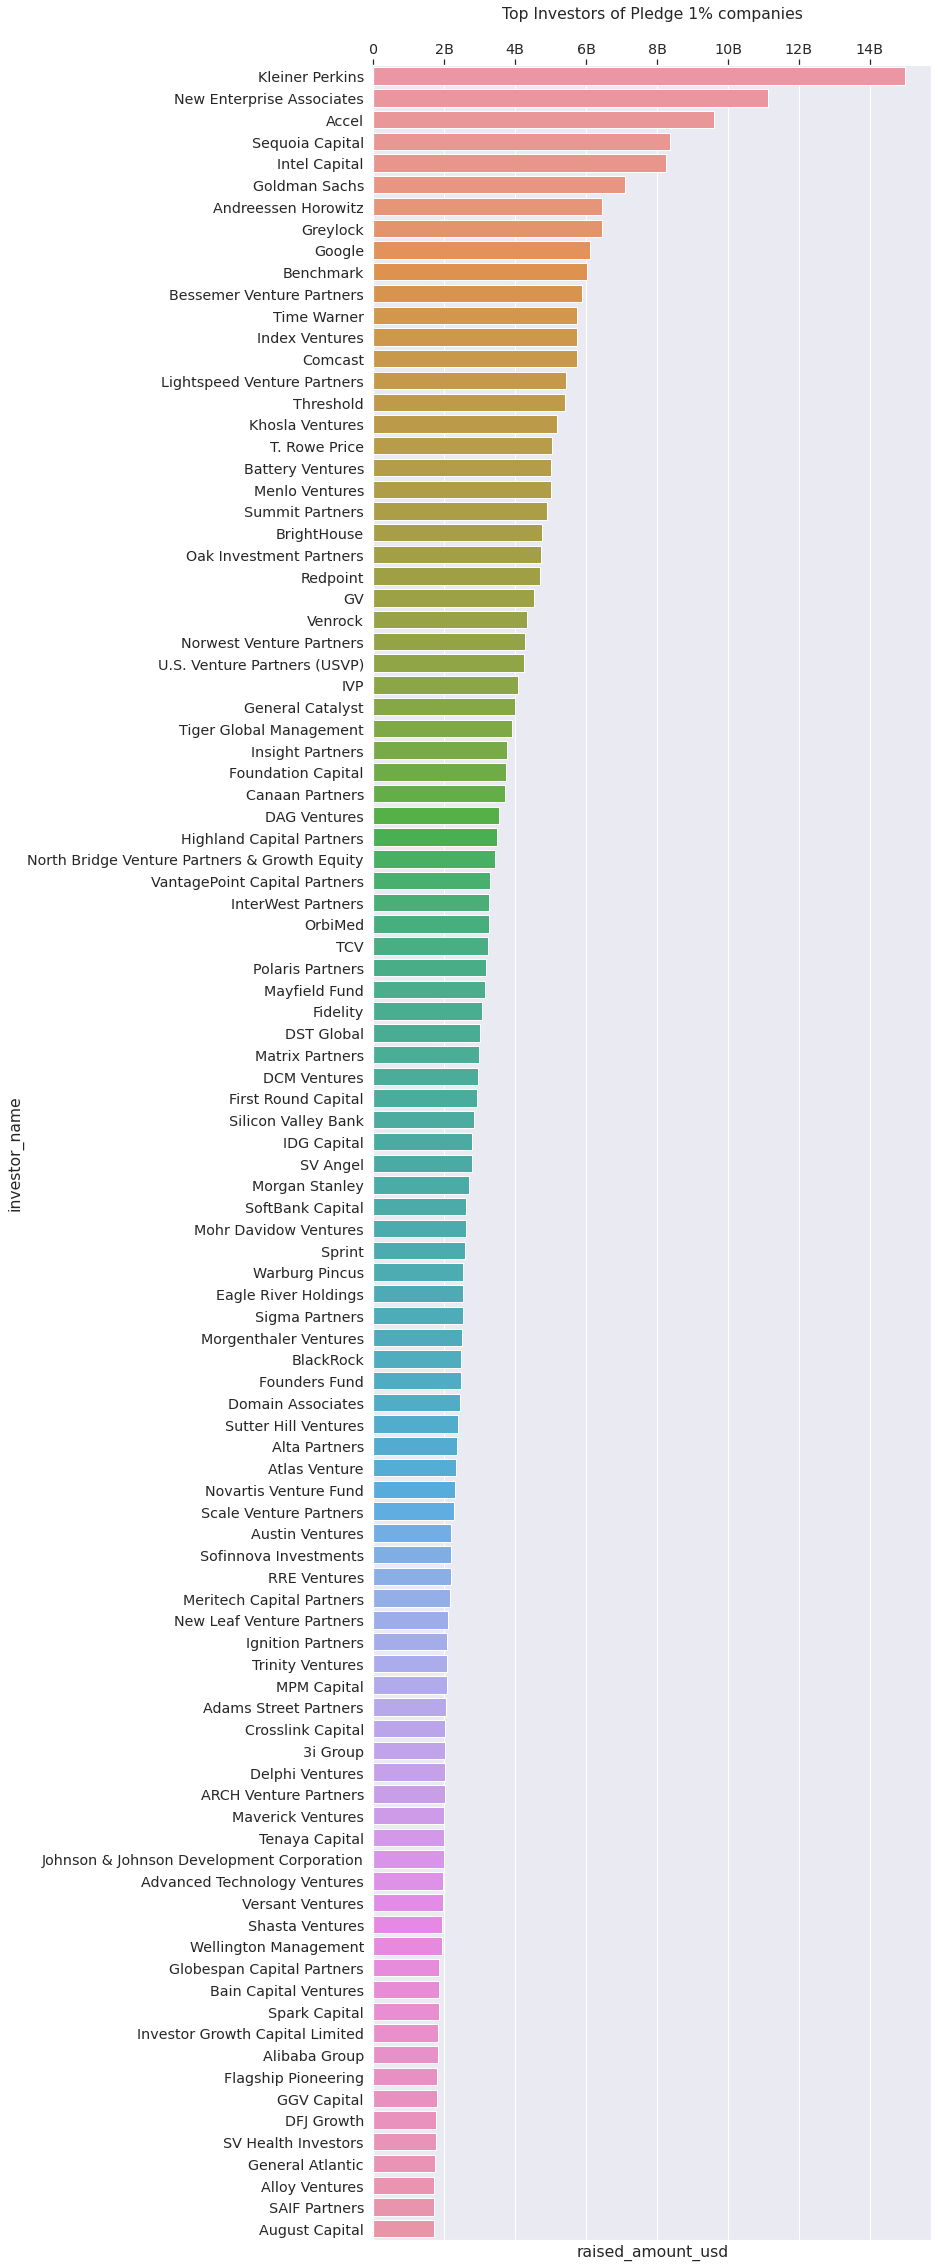

In [7]:
# Plot the graphs
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages

_, ax = plt.subplots(figsize=(10,40), sharey=True)

# p1 investors plot
ax.ticklabel_format(useOffset=False, style='plain')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(reformat_large_tick_values))
ax.set_title('Top Investors of Pledge 1% companies\n')
ax.xaxis.set_ticks_position("top")
sns.barplot(x='raised_amount_usd', y='investor_name', data=df_p1_100, orient='h', ax=ax)

_.savefig("Investor_Report.pdf", bbox_inches='tight')

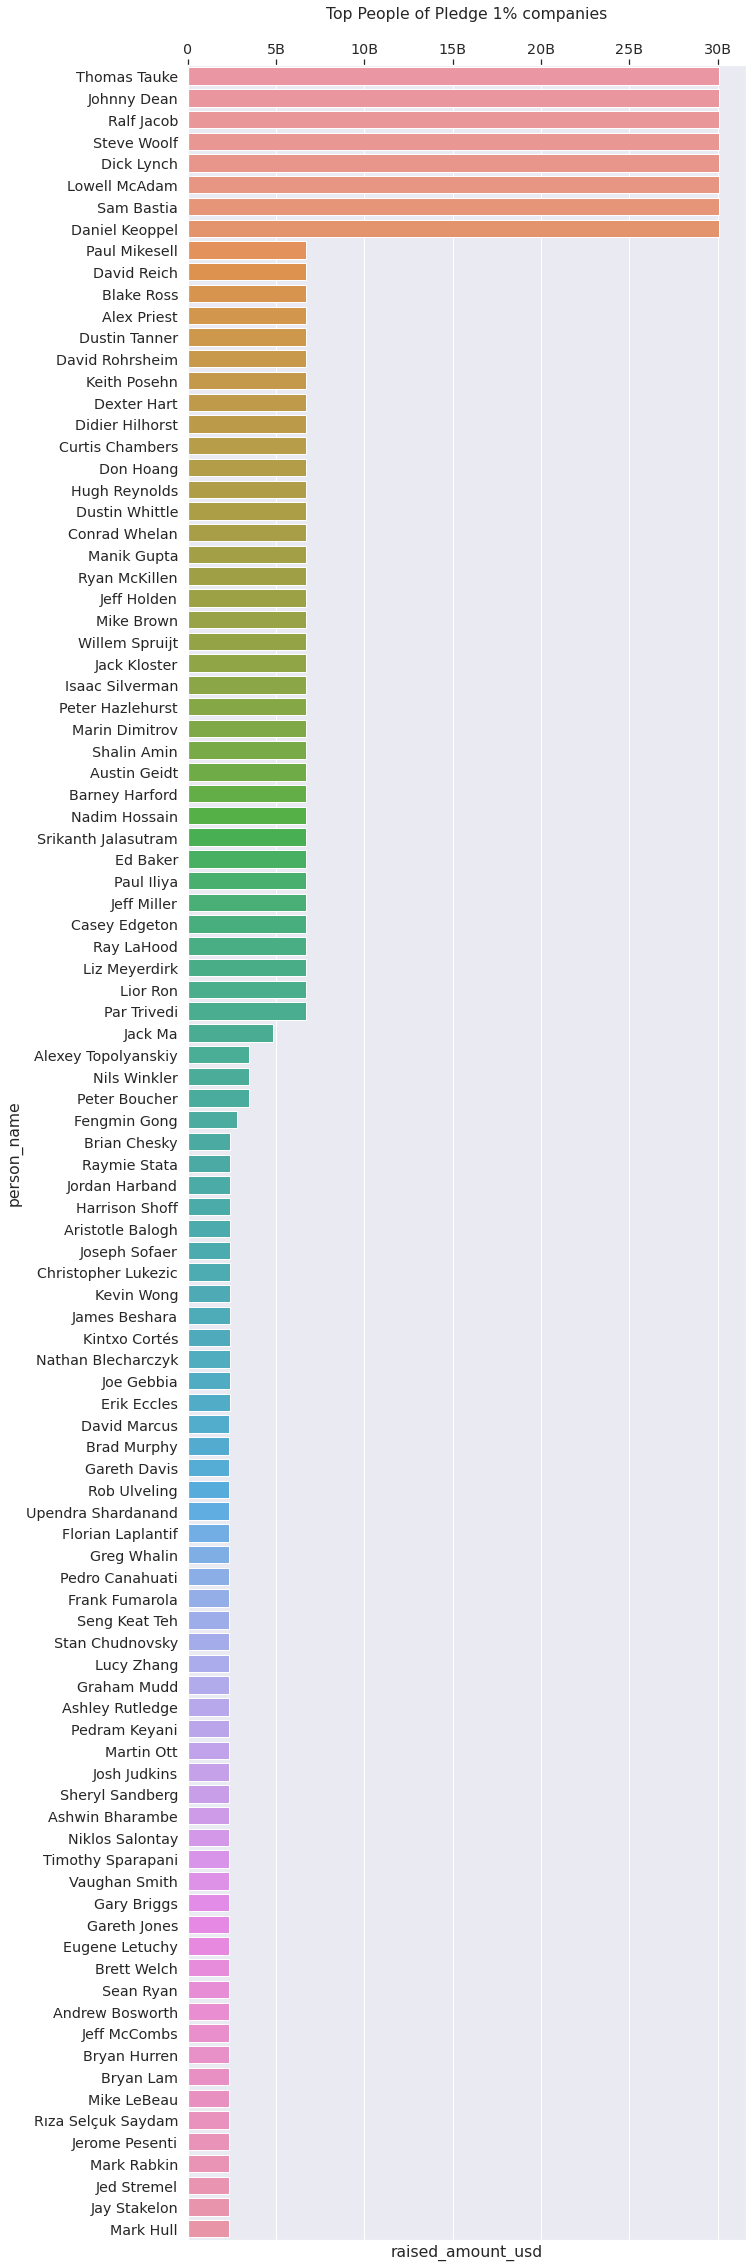

In [8]:
_, ax = plt.subplots(figsize=(10,40), sharey=True)

# p1 investors plot
ax.xaxis.set_major_formatter(ticker.FuncFormatter(reformat_large_tick_values))
ax.set_title('Top People of Pledge 1% companies\n')
ax.xaxis.set_ticks_position("top")
fig2 = sns.barplot(x='raised_amount_usd', y='person_name', data=df_p1_ppl_100, orient='h', ax=ax)

_.savefig("People_Report.pdf", bbox_inches='tight')